# Machine Learning for Vehicle Insurance Fraud Detection

This is the second part of the project, where the pre-processed data is used to train models for fraud prediction. 
As part of the business problem, we will address the end-goal for this project:

**Problem Statement**

In this project, we aim to help the insurance company to filter out potential fraud cases and minimise actual fraud cases.

**End Goal** : Create a machine learning model to predict if a specific vehicle insurance claim is a fraudulent one. 
               Supervised classification model – predict if case is fraudulent or not (Binary Classification)
               

The workflow of this machine learning section will be as follows:

1. Import relevant libraries and dataset 
2. Training multiple classification models and finding the optimal model
    - Using oversampling method ADASYN and standard scaler 
    - Using oversampling method SMOTE and standard scaler
    - Using oversampling method SMOTE, min-max scaler and standard scaler 
    - Using class weights in model training  and standard scaler 
3. Decide on the optimal model and conduct hyperparameter tuning 
4. Conclusion : Bringing in business costs to weigh the feasibility of the model

- As this is a highly imbalanced dataset, we will need to apply different techniques to deal with the imbalanced class labels. The different techniques will be applied, together with the experimentation of different scaling techniques for the dataset.
- Lastly, due to the nature of this project which deals with fraud cases, the metrics that we will be looking at would be **Recall, Precision, ROC AUC as well as Precision-Recall curve**. This is because it is much more important to catch most of the fraud cases compared to being accurate in this case. Nonetheless, it is still essential for us to bring in the actual business costs and decisions in order to decide whether the model can eventually be deployed for fraud prediction in real-life.  

# 1. Import relevant libraries and dataset 

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
import pickle
import warnings
from collections import Counter

import eli5
import scipy.stats as spstats
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline
from mlxtend.classifier import StackingClassifier
from numpy import arange, argmax
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

random = 42

In [3]:
df1 = pd.read_csv('machinelearn.csv')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         15419 non-null  int64  
 1   FraudFound_P                       15419 non-null  int64  
 2   AccidentArea_Urban                 15419 non-null  int64  
 3   Sex_Male                           15419 non-null  int64  
 4   Fault_Third Party                  15419 non-null  int64  
 5   PoliceReportFiled_Yes              15419 non-null  int64  
 6   WitnessPresent_Yes                 15419 non-null  int64  
 7   AgentType_Internal                 15419 non-null  int64  
 8   MaritalStatus_Others               15419 non-null  int64  
 9   MaritalStatus_Single               15419 non-null  int64  
 10  Days_Policy_Accident_more than 30  15419 non-null  int64  
 11  Days_Policy_Claim_more than 30     15419 non-null  int

In [5]:
df1.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
df1.head()

,FraudFound_P,AccidentArea_Urban,Sex_Male,Fault_Third Party,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,MaritalStatus_Others,MaritalStatus_Single,Days_Policy_Accident_more than 30,...,NumberOfSuppliments,Month,WeekOfMonth,DayOfWeek,Make,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,RepNumber,Age_log
0,0,1,0,0,0,0,0,0,1,1,...,0,0.083339,0.106168,0.140022,0.181594,0.218886,0.093780,0.223685,0.063363,3.091042
1,0,1,1,0,1,0,0,0,1,1,...,0,0.091510,0.236072,0.140022,0.181594,0.243660,0.093780,0.222647,0.063299,3.555348
2,0,1,1,0,0,0,0,0,0,1,...,0,0.084636,0.106168,0.158571,0.181594,0.172514,0.083339,0.241261,0.069330,3.871201
3,0,0,1,1,1,0,0,0,0,1,...,3,0.085674,0.230689,0.128543,0.202413,0.161943,0.079447,0.223685,0.059148,4.189655
4,0,1,0,1,0,0,0,0,1,1,...,0,0.091510,0.106168,0.169596,0.181594,0.218886,0.083468,0.241261,0.061547,3.332205


# 2. Training multiple classification models and finding the optimal model

In this section, we will train the dataset using several classification algorithms: 
1. Logistic Regression
2. K-Nearest Neighbour
3. Naives Bayes 
4. Random Forest
5. XGBoost
6. Gradient Boosting
7. support Vector Machine 

The best model that suits the business problem based on the metrics - Recall, ROC AUC and Precision-Recall Curve will be selected for hyperparameter tuning. 

In addition, oversampling techniques such as ADASYN and SMOTE will be used. As this is a highly imbalanced dataset (only 6% are positive labels), these techniques will be applied after the train-test split of the dataset and only on the train set. This is to prevent:
- Data Leakage 
- Idealistic situation of the reality where class labels are balanced. In reality, class labels in fraud context are always highly imbalanced. Therefore, the test dataset will not be oversampled to reflect the reality and allow the model to show its performance in a context that is close to the reality.  

Other than using oversampling techniques, we will also explore the method fo adjusting class weights to penalise the minority class labels during model training. This can be another way to deal with this set of imbalanced dataset. 

## (a) ADASYN on train dataset and Standard Scaler

In [7]:
# Define X and y dataset for Machine Learning
X = df1.iloc[:, 1::] 
y = df1.iloc[:, 0]

The function **fit_score()** will be created to perform preliminary training using baseline models: 
1. train_test_split
2. Fit and predict defined baseline models 
3. Stratified Cross Validation on train set
4. Print Classification Report , AUC Score and mean CV score for each model

In [41]:
# Define the oversampling technique to be applied 
imbal_tech = ADASYN(random_state= random)

# Define the scaling or normalisation technique to be applied
preprocessor =  StandardScaler()

# Define the classifiers to be used for model training
classifiers = {"Logistic Regression": LogisticRegression(solver = 'liblinear', random_state = random),
          "KNN": KNeighborsClassifier(n_neighbors = 5, p = 2),
          "Naives Bayes": GaussianNB(),
          "Random Forest Classifier": RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = random),
          "XGboost": XGBClassifier(objective='binary:logistic', random_state = random),
          "SVM": SVC(probability=True, random_state = random), 
          "Gradient Boosting" : GradientBoostingClassifier(n_estimators=100, random_state= random)
         }

In [42]:
# Create the function fit_score to streamline the training process and provide relevant metrics for evaluation
# In the event oversampling is done, set imbalance = True , if not, set imbalance = False 
def fit_score (X, y, imbal_tech, preprocessor, classifiers, imbalance = True):
    # Perform train test split on data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.25,
                                                    stratify= y,random_state= 111)
    
    # Create empty lists for AUC score and cross validation scores
    auc = {}
    CV = {}
    # Run a loop to go through every classifier model    
    for name, classifier in classifiers.items():
        if imbalance == True:     # if oversampling technique is applied
            pipe = Pipeline(steps=[('imbal_tech', imbal_tech), ('preprocessor', preprocessor),
                      ('classifier', classifier)])
           
        else:   # if oversampling method is not applied 
            pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
            
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
   
       
        stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random)   # Do stratified kfold for CV
    
        scores = cross_val_score(pipe, X_train, y_train, cv = stratified_kfold, scoring = 'recall')
        print(name, '\n')
        print(classification_report(y_test, y_pred))
        auc[name] = roc_auc_score(y, classifier.predict_proba(X)[:, 1])
        CV [name] = np.mean(scores) 
    
    return (print('AUC Score: \n', auc, '\n'),  print('Mean CV Score (Recall): \n', CV))

In [43]:
fit_score(X, y, imbal_tech, preprocessor, classifiers, imbalance = True)

Logistic Regression 

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      3624
           1       0.13      0.62      0.22       231

    accuracy                           0.73      3855
   macro avg       0.55      0.68      0.53      3855
weighted avg       0.92      0.73      0.80      3855

KNN 

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      3624
           1       0.12      0.50      0.20       231

    accuracy                           0.76      3855
   macro avg       0.54      0.64      0.53      3855
weighted avg       0.91      0.76      0.82      3855

Naives Bayes 

              precision    recall  f1-score   support

           0       0.98      0.63      0.77      3624
           1       0.12      0.81      0.21       231

    accuracy                           0.64      3855
   macro avg       0.55      0.72      0.49      3855
weighted avg       0.93      0.

(None, None)

Since the Naives Bayes Model and Logistic Regression Model have the highest Recall score, with decent AUC Score, we will proceed to do hyperparameter tuning for these two models and see if there can be any improvement. Mean CV score also shows that there is no overfitting of the models. 

### Hyperparameter tuning for Naives Bayes model 

In [44]:
# Perform train test split for the dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.25,
                                                    stratify= y,
                                                    random_state= 111)

Text(0.5, 1.0, 'Balanced Dataset')

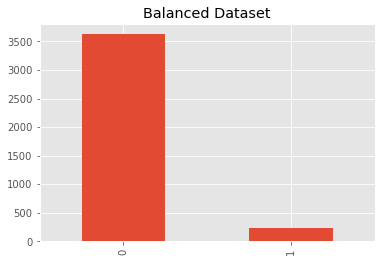

In [45]:
# Check for class distribution before oversampling is done 
pd.Series(y_test).value_counts().plot(kind="bar")
plt.title("Balanced Dataset")

In [46]:
# Apply ADASYN to only train set 
ada = ADASYN(random_state= random)
X_ada, y_ada = ada.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Balanced Dataset')

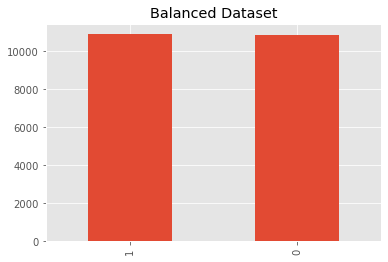

In [47]:
# Check if ADASYN is successfully applied by looking at the distribution
pd.Series(y_ada).value_counts().plot(kind="bar")
plt.title("Balanced Dataset")

In [48]:
# Scale the data using Standard Scaler
sc_ada = StandardScaler()
X_train_ada = sc_ada.fit_transform(X_ada)

X_test_ada = sc_ada.transform(X_test)
X_test_ada

array([[ 0.41653949,  0.43244556,  2.35747706, ...,  0.59558713,
        -0.94351129, -1.24126034],
       [ 0.41653949,  0.43244556, -0.42418228, ...,  0.59558713,
        -0.27210637,  0.38455112],
       [ 0.41653949, -2.3124298 , -0.42418228, ...,  0.11502033,
         0.53357955, -0.14278838],
       ...,
       [-2.40073274,  0.43244556,  2.35747706, ...,  0.59558713,
        -0.64809312, -0.65025464],
       [-2.40073274,  0.43244556, -0.42418228, ...,  0.11502033,
         0.56043574, -0.87514327],
       [ 0.41653949,  0.43244556, -0.42418228, ...,  0.11502033,
         0.29187377, -0.2387153 ]])

In [50]:
# define models and parameters
model = GaussianNB()
grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# define grid search
cv = StratifiedKFold(n_splits=10, shuffle = True,random_state= random)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv= cv, scoring='recall',error_score=0, verbose = 1)
grid_result = grid_search.fit(X_train_ada, y_ada)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   15.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.3s finished


In [51]:
#Use model to predict for test set
y_pred = grid_search.predict(X_test_ada)
print(y_pred)

[1 1 1 ... 1 1 1]


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.41      0.58      3624
           1       0.09      0.87      0.16       231

    accuracy                           0.44      3855
   macro avg       0.53      0.64      0.37      3855
weighted avg       0.93      0.44      0.56      3855



In [53]:
# Search for best params by grid search
grid_search.best_params_

{'var_smoothing': 1.0}

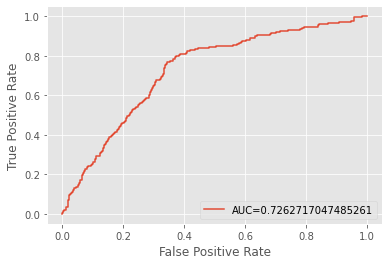

In [54]:
y_pred_proba = grid_search.predict_proba(X_test_ada)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The Naives Bayes model has a higher recall score at 0.9 after hyperparameter tuning optimizing for recall. However, this model is not a good model as the precision severely lack behind for both classes. Therefore, this model will not be used.  

### Hyperparameter tuning for Logistic Regression Model

In [55]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=10, shuffle = True,random_state= random)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring = 'recall',error_score=0, verbose = 1)
grid_result = grid_search.fit(X_train_ada, y_ada)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.2s finished


In [56]:
#Use model to predict for test set
y_pred = grid_search.predict(X_test_ada)
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.82      3624
           1       0.13      0.69      0.23       231

    accuracy                           0.71      3855
   macro avg       0.55      0.70      0.52      3855
weighted avg       0.92      0.71      0.79      3855



In [58]:
# Search for best params by grid search
grid_search.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

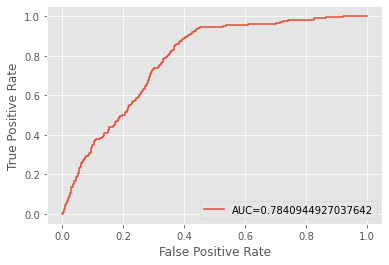

In [59]:
y_pred_proba = grid_search.predict_proba(X_test_ada)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The results looks decent and there is an improvement in recall and AUC score from the baseline log regression model. 
We will KIV this model for a final evaluation later on. 

We shall now explore using another oversampling method - SMOTE with standard scaler.

## (b) Using SMOTE on train set and Standard Scaler 

Use function fit_score to do training using baseline models.

In [63]:
# Define the oversampling technique to be applied 
imbal_tech = SMOTE(random_state= random)

# Define the scaling or normalisation technique to be applied
preprocessor =  StandardScaler()

# Define the classifiers to be used for model training
classifiers = {"Logistic Regression": LogisticRegression(solver = 'liblinear', random_state = random),
          "KNN": KNeighborsClassifier(n_neighbors = 5, p = 2),
          "Naives Bayes": GaussianNB(),
          "Random Forest Classifier": RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = random),
          "XGboost": XGBClassifier(objective='binary:logistic', random_state = random),
          "SVM": SVC(probability=True, random_state = random), 
          "Gradient Boosting" : GradientBoostingClassifier(n_estimators=100, random_state= random)
         }




fit_score (X, y, imbal_tech, preprocessor, classifiers, imbalance = True)

Logistic Regression 

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      3624
           1       0.13      0.62      0.22       231

    accuracy                           0.73      3855
   macro avg       0.55      0.68      0.53      3855
weighted avg       0.92      0.73      0.80      3855

KNN 

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      3624
           1       0.13      0.53      0.21       231

    accuracy                           0.76      3855
   macro avg       0.55      0.65      0.53      3855
weighted avg       0.91      0.76      0.82      3855

Naives Bayes 

              precision    recall  f1-score   support

           0       0.98      0.63      0.77      3624
           1       0.12      0.82      0.21       231

    accuracy                           0.64      3855
   macro avg       0.55      0.72      0.49      3855
weighted avg       0.93      0.

C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(None, None)

Results seem to be highly similar to the results from ADASYN oversampling technique. Therefore, we will not go ahead to do the hyperparameter tuning for any models. Instead, we will explore model stacking as part f the emsemble technique to see if we can get a better result. The models selected for stacking would be logistic regression, KNN and naives bayes. These models are chosen as they have better recall and AUC scores. 

## Stacking Models ( Ensemble Technique)

In [64]:
# Carry out SMOTE on the train dataset only to deal with imbalanced data 
sm = SMOTE(random_state= random)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [65]:
# Scale the X train and X test set using Standard scaler 
sc_1 = StandardScaler()
X_train_SMOTE = sc_1.fit_transform(X_res)
X_test_SMOTE = sc_1.transform(X_test)

In [66]:
# Define the models to be used and the stacking classifier 
clf1 = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'distance')
clf2 = GaussianNB()
lr = LogisticRegression(solver = 'liblinear', class_weight = 'balanced', random_state = random)
sclf = StackingClassifier(classifiers=[clf1, clf2],
                          use_probas=True,         # 
                          average_probas=False,
                          meta_classifier=lr)

print('5-fold cross validation:\n')
# Perform Cross validation base don AUC score for all models
for clf, label in zip([clf1, clf2, sclf], 
                      ['KNN', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train_SMOTE, y_res, 
                                              cv=5, scoring='roc_auc')
    
    test_scores = cross_val_score(clf, X_test_SMOTE, y_test, 
                                              cv=5, scoring='roc_auc')
    print("Recall: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    print("Recall: %0.2f (+/- %0.2f) [%s]" 
          % (test_scores.mean(), scores.std(), label))

5-fold cross validation:

Recall: 0.96 (+/- 0.01) [KNN]
Recall: 0.65 (+/- 0.01) [KNN]
Recall: 0.86 (+/- 0.04) [Naive Bayes]
Recall: 0.76 (+/- 0.04) [Naive Bayes]
Recall: 0.96 (+/- 0.01) [StackingClassifier]
Recall: 0.76 (+/- 0.01) [StackingClassifier]


There are signs of overfitting in all models as the CV score in the test set is much lower than the train set. 

In [67]:
sclf.fit(X_train_SMOTE, y_res)
y_pred = sclf.predict(X_test_SMOTE)

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      3624
           1       0.13      0.53      0.21       231

    accuracy                           0.76      3855
   macro avg       0.55      0.65      0.53      3855
weighted avg       0.91      0.76      0.82      3855



Text(0.5, 1.0, 'AUC')

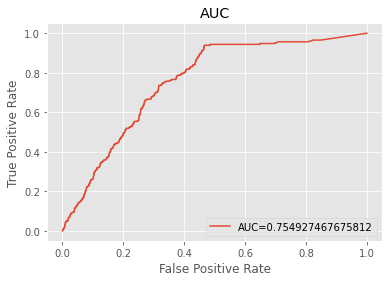

In [69]:
y_pred_proba = sclf.predict_proba(X_test_SMOTE)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('AUC')

Text(0.5, 1.0, 'Precision-Recall Curve')

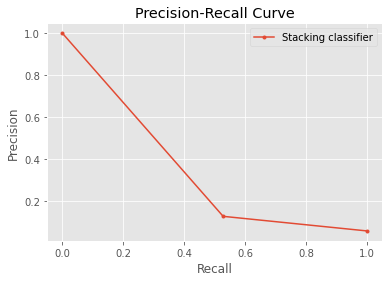

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Stacking classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Precision-Recall Curve')

Although AUC score is not too bad, recall score is not as good as expected. There are also signs of overfitting as well. 

Counter({0: 2911, 1: 944})


Text(0.5, 1.0, 'Probabilities for Positive Class')

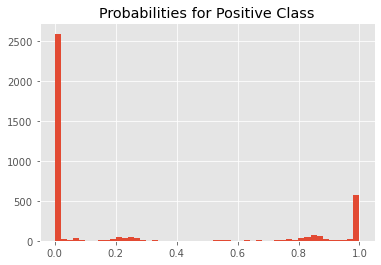

In [71]:
# summarize the distribution of predicted probabilities for positive class

sclf.fit(X_train_SMOTE, y_res)
yhat = sclf.predict_proba(X_test_SMOTE)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = sclf.predict(X_test_SMOTE)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
plt.hist(pos_probs, bins=50)
plt.title('Probabilities for Positive Class')

The probabilities of positive class seem to be on the low side. We shall now explore if finding the optimal probability threshold will help to improve the results. 

In [74]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = sclf.predict_proba(X_test_SMOTE)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.190, F-Score=0.22385


In [77]:
y_pred_new_threshold = (sclf.predict_proba(X_test_SMOTE)[:,1]>=thresholds[ix]).astype(int)
y_pred_new_threshold

array([0, 1, 0, ..., 0, 0, 0])

In [78]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      3624
           1       0.13      0.66      0.22       231

    accuracy                           0.72      3855
   macro avg       0.55      0.70      0.53      3855
weighted avg       0.92      0.72      0.80      3855



Adjusting the optimal threshold helps slightly but it is still not the best model due to signs of overfitting. 

We will now explore whether the use of min-max scaler for the categorical features and standard scaler for the continuous features will yield better results.

##  (C) Using SMOTE on train set , MinMax Scaler and Standard Scaler 

For this iteration, min max scaler is used for categorical features while standard scaler is used for continuous features. The oversmapling technique used will still be SMOTE.

In [80]:
# Define the oversampling technique to be applied 
imbal_tech = SMOTE(random_state= random)

# Define the scaling or normalisation technique to be applied

# For Numeric column - Age_log
numeric_transformer = Pipeline(steps=[('numscaler', StandardScaler())])
numeric_features = (df1.iloc[:, -1:]).columns

# For all other categorical columns 
categorical_transformer = Pipeline(steps=[('catscaler', MinMaxScaler())])
categorical_features = (df1.iloc[:, 1:-1]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Define the classifiers to be used for model training
classifiers = {"Logistic Regression": LogisticRegression(solver = 'liblinear', random_state = random),
          "KNN": KNeighborsClassifier(n_neighbors = 5, p = 2),
          "Naives Bayes": GaussianNB(),
          "Random Forest Classifier": RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = random),
          "XGboost": XGBClassifier(objective='binary:logistic', random_state = random),
          "SVM": SVC(probability=True, random_state = random), 
          "Gradient Boosting" : GradientBoostingClassifier(n_estimators=100, random_state= random)
         }

In [81]:
fit_score (X, y, imbal_tech, preprocessor, classifiers, imbalance = True)

Logistic Regression 

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      3624
           1       0.13      0.64      0.22       231

    accuracy                           0.73      3855
   macro avg       0.55      0.69      0.53      3855
weighted avg       0.92      0.73      0.80      3855

KNN 

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3624
           1       0.12      0.52      0.20       231

    accuracy                           0.75      3855
   macro avg       0.54      0.64      0.53      3855
weighted avg       0.91      0.75      0.81      3855

Naives Bayes 

              precision    recall  f1-score   support

           0       0.98      0.63      0.77      3624
           1       0.12      0.82      0.21       231

    accuracy                           0.64      3855
   macro avg       0.55      0.72      0.49      3855
weighted avg       0.93      0.

C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(None, None)

Confusion matrix results are highly similar to the previous results. It seems that using min max scaler and standard scaler for categorical and continuous features respectively does not really improve the results. In fact, the AUC scores are much worse off. Hence, we will now explore adjusting class weights for the labels. 

## (d) Adjusting Class weights in ML and Standard Scaler

In [82]:
# No oversampling technique is needed, thus we assign it to an empty list
imbal_tech = []

# Define the scaling or normalisation technique to be applied
preprocessor =  StandardScaler()

# Define the classifiers to be used for model training
classifiers = {"Logistic Regression": LogisticRegression(solver = 'liblinear', class_weight = 'balanced', random_state = random),
          "KNN": KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'distance'),
          "Random Forest Classifier": RandomForestClassifier(n_estimators = 50, criterion = 'entropy', class_weight = 'balanced', random_state = random),
          "XGboost": XGBClassifier(scale_pos_weight= 15.7 , objective='binary:logistic', random_state =random),
           "SVM": SVC(class_weight={0:1.0, 1:15.7}, probability=True, random_state = random)}


In [83]:
# set imbalance = False as there are no oversampling techniques to be applied
fit_score (X, y, imbal_tech, preprocessor, classifiers, imbalance = False)

Logistic Regression 

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      3624
           1       0.13      0.91      0.22       231

    accuracy                           0.62      3855
   macro avg       0.56      0.75      0.48      3855
weighted avg       0.94      0.62      0.71      3855

KNN 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3624
           1       0.27      0.03      0.06       231

    accuracy                           0.94      3855
   macro avg       0.60      0.51      0.51      3855
weighted avg       0.90      0.94      0.91      3855

Random Forest Classifier 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       1.00      0.01      0.03       231

    accuracy                           0.94      3855
   macro avg       0.97      0.51      0.50      3855
weighted avg       

(None, None)

The Recall score for logistic regression is highest at 0.91. The AUC Score for logistic regression is also pretty decent at 0.796. There is no overfitting for the model as well.
Therefore, we will proceed to do hyper-parameter tuning for logistic regression model. 

### Hyper-parameter tuning for logistic regression model

In [84]:
# Scale the X train and X test using standard scaler
stand_scal = StandardScaler()
X_train_scal = stand_scal.fit_transform(X_train)

In [85]:
# Only do transform on test set 
X_test_scal = stand_scal.transform(X_test)

In [86]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1']
c_values = [100, 10, 1.0, 0.1, 0.01]
class_weight = ['balanced']

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, class_weight = class_weight)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv ,scoring = 'f1',error_score=0, verbose = 1)
grid_result = grid_search.fit(X_train_scal, y_train)

Fitting 30 folds for each of 30 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 587 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  7.5min finished


In [315]:
y_pred = grid_search.predict(X_test_scal)
y_pred

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [316]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      3624
           1       0.13      0.92      0.22       231

    accuracy                           0.61      3855
   macro avg       0.56      0.76      0.48      3855
weighted avg       0.94      0.61      0.71      3855



In [87]:
#Best parameters from grid search
grid_search.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

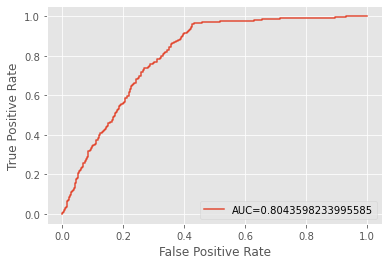

In [88]:
y_pred_proba = grid_search.predict_proba(X_test_scal)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

The recall results improved by 0.02 and the AUC score also increased. This seems to be the best model out of all models based on the selected metrics. 

# 3. Selecting the best model - Logistic Regression Model with class weights adjusted and standard scaler

The best model out of all trained models is the Logistic Regression Model with class weights adjusted for the imbalanced dataset and data scaled with standard scaler after hyperparameter tuning using gridsearchCV. This is evaluated based on the metrics - Recall and AUC Score. 
The recall and AUC score for the best model is the highest among all. Thus, we will select this model and further evaluate its feasibility with business impacts. 

In [89]:
# Create an instance of the logistic regression classifier with the best parameters from grid search
classifier = LogisticRegression(C = 0.01, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')

In [90]:
# Fit the model
classifier.fit(X_train_scal, y_train)

LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

In [91]:
# Predict results using the model 
y_pred= classifier.predict(X_test_scal)
y_pred

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      3624
           1       0.13      0.92      0.22       231

    accuracy                           0.61      3855
   macro avg       0.56      0.76      0.48      3855
weighted avg       0.94      0.61      0.71      3855



[[2151 1473]
 [  19  212]]


<AxesSubplot:>

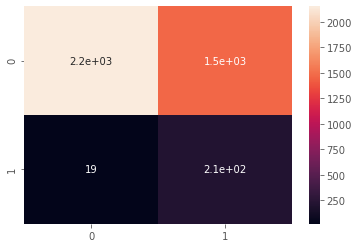

In [93]:
# Visualise the confusion matrix 
cm= confusion_matrix(y_test, y_pred)  

print(cm)

sns.heatmap(cm, annot=True)

In [94]:
# Check for CV score based on recall to ensure that there is no overfitting 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state= random)
scores = cross_val_score(classifier, X_train_scal, y_train, scoring='recall', cv=cv, n_jobs=-1)
print('Mean recall-Score: %.4f' % np.mean(scores))

Mean recall-Score: 0.8946


No overfitting of the model is observed as the mean CV score for the train set is slightly lower than the recall score on the test set. 

Text(0.5, 1.0, 'ROC-AUC Curve')

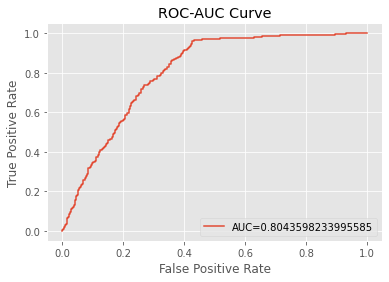

In [95]:
y_pred_proba = classifier.predict_proba(X_test_scal)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC-AUC Curve')

Text(0.5, 1.0, 'Precison-Recall Curve')

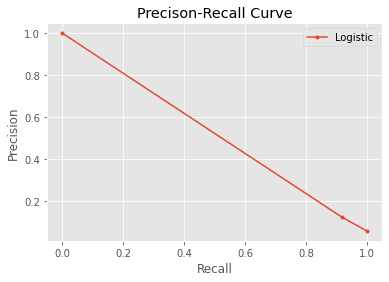

In [96]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Precision-Recall Curve')

Although not the perfect model, the AUC score and precision-recall curve shows that this model still has skill in differentiating the classes at different probability threshold. 

Let us look at the distribution of probabilities for the positive class. 

Counter({0: 2170, 1: 1685})


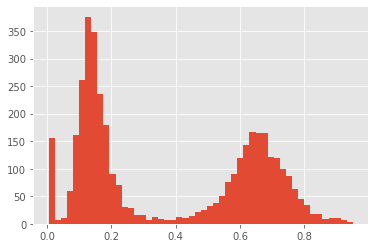

In [97]:
# summarize the distribution of predicted probabilities of positive class

classifier.fit(X_train_scal, y_train)
yhat = classifier.predict_proba(X_test_scal)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# predict class labels
yhat = classifier.predict(X_test_scal)
# summarize the distribution of class labels
print(Counter(yhat))
# create a histogram of the predicted probabilities
plt.hist(pos_probs, bins=50)
plt.show()

**Overall:** 

- 212 out of 231 (92%) fraud cases are caught by model, probability > 0.5
- 19 (8%) fraud cases undetected , probability < 0.5
- 1473 flagged transactions but not fraud cases (false positive)

At this point, there is a need to bring in the costs of Type I error and Type II error to decide whether the model can be deployed as it is. Although the recall is good and catch most of the fraud cases, there is a high number of false positives , which means that the comapny will have to spend more on cost of monitoring and investigating for flagged transactions. In this case, the cost of false postitives might more than the cost of undetected fraud or it might be significantly higher than what the company is willing to spend. Therefore, we will need to know the true costs in order to determine whether the optimal probability threshold should be adjusted furtehr for this model before deployment. 

1. False positives (Type I error) --- incur cost of human labour for investigating the flagged transactions
2. False negatives (Type II error) --- incur cost of undetected fraud

**In the event in which the cost of monitoring and investigation > cost of undetected fraud, we will shift the probability threshold to the right to decrease false positives cases**

**In the event in which the cost of undetected fraud > cost of monitoring and investigation, we will shift the probability threshold to the left to catch more fraud cases but with the expense of higher false positive cases.** 

## (a) Adjusting probability threshold for increase recall - catch more fraud cases

From the probability distribution, it seems to be bimodal and most of the fraud cases tend to fall on the right side of the distribution. In the event in which the cost of undetected fraud > cost of monitoring and investigation, we will shift the probability threshold to the left to catch more fraud cases but with the expense of higher false positive cases.

Thus, looking at the probability distribution, we will explore setting the threshold at 0.4, at the cut-off point where the distinction between the 2 distinct groups shows the most. This will likely catch more fraud cases, but with an increase in false positive cases.

In [103]:
# Predict for x test with a probability threshold of 0.4
y_pred_new_threshold = (classifier.predict_proba(X_test_scal)[:,1]>=0.4).astype(int)
y_pred_new_threshold

array([0, 1, 0, ..., 0, 1, 1])

In [104]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73      3624
           1       0.13      0.96      0.22       231

    accuracy                           0.60      3855
   macro avg       0.56      0.77      0.47      3855
weighted avg       0.94      0.60      0.70      3855



[[2075 1549]
 [   9  222]]


<AxesSubplot:>

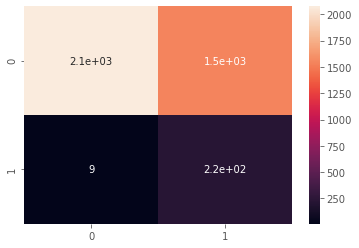

In [105]:
cm= confusion_matrix(y_test, y_pred_new_threshold)  

print(cm)

sns.heatmap(cm, annot=True)

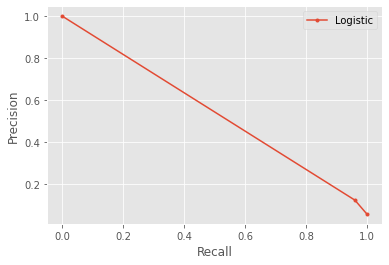

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_new_threshold)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

Indeed, the model caught 10 more fraud cases but there are 76 more false positive cases. At this point, if the cost of monitoring and investigating is still kept under control and did not exceed the cost of undetected fraud, this model will be deployable with probability threshold set at 0.4. 

## (b) Adjusting probability threshold to reduce the cost of monitoring and investigation

In the event in which the cost of monitoring and investigation > cost of undetected fraud, we will shift the probability threshold to the right to decrease false positives cases and cost of investigating flagged transactions. 

For this section, we will explore optimising the F1-score to get a balance between precision and recall. The probability threshold will likely shift to the left. 

In [107]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = grid_search.predict_proba(X_test_scal)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.640, F-Score=0.24843


In [108]:
#Predict for x test with a probability threshold of 0.640
y_pred_new_threshold = (grid_search.predict_proba(X_test_scal)[:,1]>=thresholds[ix]).astype(int)
y_pred_new_threshold

array([0, 1, 0, ..., 0, 0, 1])

In [109]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3624
           1       0.15      0.68      0.25       231

    accuracy                           0.75      3855
   macro avg       0.56      0.72      0.55      3855
weighted avg       0.92      0.75      0.82      3855



[[2741  883]
 [  73  158]]


<AxesSubplot:>

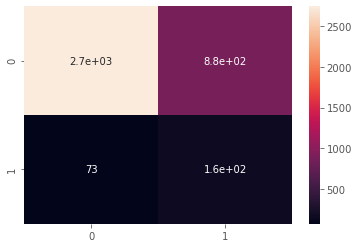

In [110]:
cm= confusion_matrix(y_test, y_pred_new_threshold)  

print(cm)

sns.heatmap(cm, annot=True)

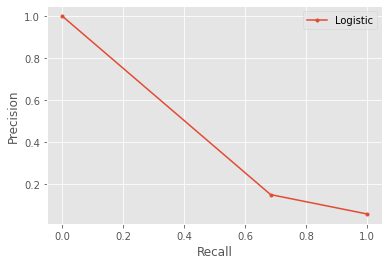

In [111]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_new_threshold)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

The probability threshold has shifted left to 0.640, causing less fraud cases to be detected but the company is able to save a lot more on the cost of monitoring and investigating due to the decrease in false positives. 

In conclusion, the real costs incurred by the stakeholders are essential to determine if the model needs to be further adjusted for probability threshold before deployment. 

## Feature Importance

In [112]:
classifier.fit(X_train_scal, y_train)
#Create a dataframe to store sttributes and its coeficients 
importances = pd.DataFrame(data={
    'Attribute': df1.iloc[:, 1::] .columns,
    'Importance': classifier.coef_[0]
})

#Sort by coefficients 
importances = importances.sort_values(by='Importance', ascending=False)

<Figure size 864x720 with 0 Axes>

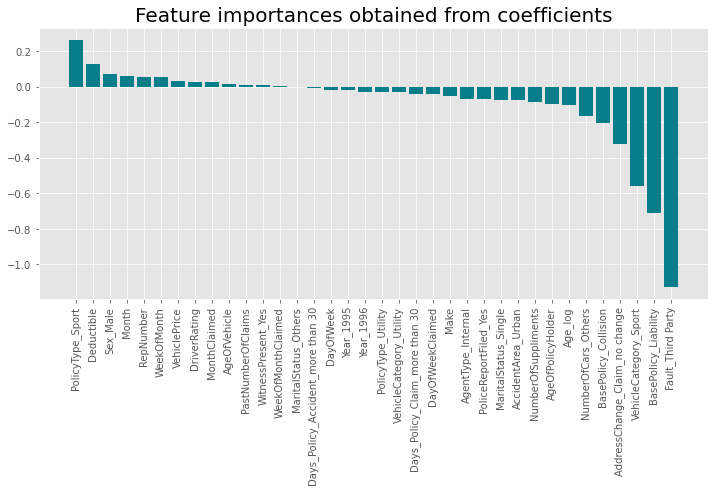

<Figure size 864x720 with 0 Axes>

In [119]:
# Plot the feature importance through coefficients for each attributes 
plt.subplots(figsize = (12,5))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.figure(figsize=(12,10))

# Positive coeficients shows the weights for attributes that contribute to the prediction of positive class
# Negative coeficients shows the weights for attributes that contribute to the prediction of negative class

In [114]:
# Run eli5 to double confirm the weights of each attribute
eli5.show_weights(classifier)

In [115]:
# Create dataframe to link the features to the column number for interpretation purpose
pd.DataFrame(data = X.columns, columns= {'Features'})

,Features
0,AccidentArea_Urban
1,Sex_Male
2,Fault_Third Party
3,PoliceReportFiled_Yes
4,WitnessPresent_Yes
5,AgentType_Internal
6,MaritalStatus_Others
7,MaritalStatus_Single
8,Days_Policy_Accident_more than 30
9,Days_Policy_Claim_more than 30


From the above plots, the top 6 features that contribute to the prediction of a fraud case are:
1. AccidentArea_urban
2. Sex_Male
3. Fault_Third Party
4. Police_report_filed_yes
5. Witness_present_yes
6. AgentType_Internal

**Finally , save the classifier model for future deployment.**

In [118]:
# Save the trained model as a pickle string.
filename = 'trained_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

#Loading saved model 
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

#loaded_model.predict()

# 4. Conclusion : Bringing in business impacts to weigh the feasibility of the model

In the context of detecting fraud cases , the perfect model would be able to detect all the true fraud cases and yet not flag out any of the non-fraud transactions as fraud cases. In other words, there should be only true positives and true negatives. However, this is not realistic in machine learning models. Since this is a model to detect fraud, it is essential that we catch most of the fraud cases (Recall), while keeping the cost to monitor and investigate fraud cases flagged out by the model under control(Precision). As such , there is a need to balance between precision and recall, which is seen in the F1-score. Using F1-score as a metric is feasible if the cost of Type I and Type II errors are the same. However, in the context of fraud, the cost for type I and type II errors are not assymmetrical, which calls for the need to bring in the real cost of these errors from the stakeholders. 

In this project, the model selected has high recall at 0.91, which means that most of the fraud cases are captured by the model. However, there is a trade-off in the precision for the positive class , where precision is pretty low at 0.13. This indicates that there are a significant portion of false positive cases.

- **False positives (Type I error) --- incur cost of human labour for investigating the flagged transactions**
- **False negatives (Type II error) --- incur cost of fraud**

As such, we will have to look at these two types of cost incurred in order to determine the optimal probability threshold to precision and recall. The model can only be deployed if the cost of human labour to investigate flagged fraud cases is significantly lower than the the cost of true fraud cases that the model did not catch. Thus, it would be important to analyse the business impact of the model before deployment. 

## Way ahead to incorporate business impact into the model:

1. Adjusting class weights during machine learning using the true cost ratio 
    - Find out the labour cost needed for investigation (e.g cost of monitoring per fraud case) and the cost of uncaught fraud (e.g the average cost of an undetected fraud case) 
    - Calculate the cost ratio and adjust the class weights accordingly (customised class weights) in the model training process.
    
    
2. Adjusting the probability threshold to balance the cost of type I errors and type II errors accordingly. 

3. Optimising for F1-score , which balances precision and recall of the model. 



## How can we improve this model? 

1. Include more relevant features in the machine learning process
    - From the feature importance plot and ELI5 results of the selected model, the weights of the features that lead to the prediction of positive class are not as high. There are also lesser influencing features for the prediction of positive class.This shows that the features in the dataset might not be relevant enough for prediction.
    - Increasing relevant features and removing those that are less relevant might improve the model
    
    
2. Increase the size of data to get a bigger portion of insurance claims that are fraudulent
    - As this is a highly imbalanced dataset, there are challenges when it comes to model training. Oversampling techniques and adjusting class weights might still not be the ideal solution in some cases. Although it is hard to get a larger proportion of fraud cases, it can help significantly in model training if there are enough positive labels. 